# Twitter Sentiment Analysis

## Importing Libraries

In [0]:
from fastai.text import * 

# fastai needs us to specify a path sometimes
from pathlib import Path

# Import usual data science libraries
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

### Loading the dataset

In [0]:
path = Path('/content/twitter-airline-sentiment')
file_name = 'Tweets.csv'

In [55]:
file_path = path / file_name
df_full = pd.read_csv(file_path)
df_full.size

219600

In [0]:
pd.set_option('display.max_colwidth', 0)

### Selecting only Sentiments and Tweet

In [57]:
df = df_full[['airline_sentiment', 'text']]
df.sample(10)

,airline_sentiment,text
8919,neutral,@JetBlue how do I get a copy of my last flight showing original time and delay? I need it for work. Thanks!
5812,negative,@SouthwestAir Weather seriously cannot even be the only excuse at this point because it was awful service in the summer too. Over it.
2091,negative,"@united more people stranded cause you suck. Better yet, you weasel out of Flight Booking Problems rooms for people claiming weather http://t.co/Flcnnn2USD"
8454,neutral,@JetBlue Can you do me a huge favor?!🙏❤️
10121,negative,@USAirways Thanks for Cancelled Flighting my flight tomorrow and not reFlight Booking Problems me on another one. #usairwaysfail
262,negative,@VirginAmerica #wtf I paid for direct flight on purpose not to have to stop for fuel exhausted frequent flier and nothing for inconvenience!
12951,negative,"@AmericanAir I paid using Paypal online and after I was charged there was a ""System Error"" which is what I ended up calling about."
7117,neutral,❤️❤️❤️“@JetBlue: Our fleet's on fleek. http://t.co/UHUmAskLdv”
6282,neutral,@SouthwestAir @love_dragonss LAUREN HoLY SHT
1086,positive,@united great to hear Thankyou so much. Greatly appreciate your replies. Feel much more settled now.


### Checking NULL values

In [58]:
df[['airline_sentiment', 'text']].isna().sum()

airline_sentiment    0
text                 0
dtype: int64

In [59]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [60]:
df['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

## Relationship between Airline and Sentiments

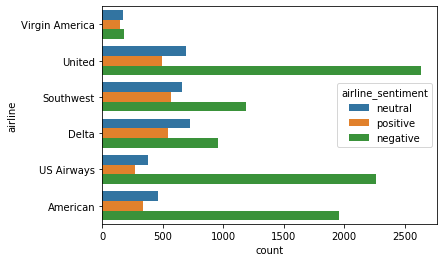

In [61]:
sns.countplot(y='airline', hue='airline_sentiment', data=df_full)

### Converting to Lowercase

In [62]:
df["text_lower"] = df["text"].str.lower()
df.head()

,airline_sentiment,text,text_lower
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it


### Importing Libaries

In [0]:
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

### Removal of String Punctuation

This is again a text standardization process that will help to treat 'chirag' and 'chirag!' in the same way.
We also need to carefully choose the list of punctuations to exclude depending on the use case. For
example, the string.punctuation in python contains the following punctuation symbols
!"#$%&\'()*+,-./:;<=>?@[\\]^_ {|}~`
We can add or remove more punctuations as per our need.

In [64]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df["text_lower"].apply(lambda text: remove_punctuation(text))
df.head()

,airline_sentiment,text,text_lower,text_wo_punct
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials to the experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica i didnt today must mean i need to take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its a really big bad thing about it


In [65]:
df.columns

Index(['airline_sentiment', 'text', 'text_lower', 'text_wo_punct'], dtype='object')

In [66]:
df.head()

,airline_sentiment,text,text_lower,text_wo_punct
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials to the experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica i didnt today must mean i need to take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its a really big bad thing about it


### Removal of Frequent Words

In [67]:
from collections import Counter
cnt = Counter()
for text in df["text_wo_punct"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('to', 8640),
 ('the', 6050),
 ('i', 5372),
 ('a', 4476),
 ('united', 4117),
 ('you', 4105),
 ('for', 3991),
 ('flight', 3870),
 ('on', 3778),
 ('and', 3709)]

In [68]:
df.head()

,airline_sentiment,text,text_lower,text_wo_punct
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials to the experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica i didnt today must mean i need to take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its a really big bad thing about it


In [69]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(6)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_punct"].apply(lambda text: remove_freqwords(text))
df.head()

,airline_sentiment,text,text_lower,text_wo_punct,text_wo_stopfreq
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said,virginamerica what dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials to the experience tacky,virginamerica plus youve added commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica i didnt today must mean i need to take another trip,virginamerica didnt today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its a really big bad thing about it,virginamerica and its really big bad thing about it


### Removal of Rare words

In [70]:
# Drop the two columns which are no more needed 
df.drop(["text_wo_punct"], axis=1, inplace=True)

n_rare_words = 100
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_freqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()

,airline_sentiment,text,text_lower,text_wo_stopfreq,text_wo_freqrare
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said,virginamerica what dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials experience tacky,virginamerica plus youve added commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and its really big bad thing about it


In [71]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Stemming
Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or
root form.
There are several type of stemming algorithms available and one of the famous one is porter stemmer
which is widely used. We can use nltk package for the same.

In [72]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["text_stemmed"] = df["text_wo_freqrare"].apply(lambda text: stem_words(text))
df.head()

,airline_sentiment,text,text_lower,text_wo_stopfreq,text_wo_freqrare,text_stemmed
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials experience tacky,virginamerica plus youve added commercials experience tacky,virginamerica plu youv ad commerci experi tacki
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take anoth trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica it realli aggress blast obnoxi entertain in your guest face amp they have littl recours
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and it realli big bad thing about it


In [73]:
print("Word is : stripes")
print("Lemma result for verb : ",lemmatizer.lemmatize("stripes", 'v'))
print("Lemma result for noun : ",lemmatizer.lemmatize("stripes", 'n'))

Word is : stripes
Lemma result for verb :  strip
Lemma result for noun :  stripe


In [74]:
df.head(10)

,airline_sentiment,text,text_lower,text_wo_stopfreq,text_wo_freqrare,text_stemmed
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials experience tacky,virginamerica plus youve added commercials experience tacky,virginamerica plu youv ad commerci experi tacki
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take anoth trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica it realli aggress blast obnoxi entertain in your guest face amp they have littl recours
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and it realli big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,@virginamerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying va,virginamerica seriously would pay 30 flight for seats that didnt have this playing its really only bad thing about flying va,virginamerica seriously would pay 30 flight for seats that didnt have this playing its really only bad thing about flying va,virginamerica serious would pay 30 flight for seat that didnt have thi play it realli onli bad thing about fli va
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)","@virginamerica yes, nearly every time i fly vx this “ear worm” won’t go away :)",virginamerica yes nearly every time fly vx this “ear worm” won’t go away,virginamerica yes nearly every time fly vx this “ear worm” won’t go away,virginamerica ye nearli everi time fli vx thi “ear worm” won’t go away
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP","@virginamerica really missed a prime opportunity for men without hats parody, there. https://t.co/mwpg7grezp",virginamerica really missed prime opportunity for men without hats parody there httpstcomwpg7grezp,virginamerica really missed prime opportunity for men without hats parody there httpstcomwpg7grezp,virginamerica realli miss prime opportun for men without hat parodi there httpstcomwpg7grezp
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D","@virginamerica well, i didn't…but now i do! :-d",virginamerica well didnt…but now do d,virginamerica well didnt…but now do d,virginamerica well didnt…but now do d
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.","@virginamerica it was amazing, and arrived an hour early. you're too good to me.",virginamerica it was amazing and arrived an hour early youre too good me,virginamerica it was amazing and arrived an hour early youre too good me,virginamerica it wa amaz and arriv an hour earli your too good me


In [75]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
## Lemmatization
Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way
that it makes sure the root word (also called as lemma) belongs to the language.
As a result, this one is generally slower than stemming process. So depending on the speed requirement,
we can choose to use either stemming or lemmatization.
Let us use the WordNetLemmatizer in nltk to lemmatize our sentences

In [76]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_freqrare"].apply(lambda text: lemmatize_words(text))
df.head()

,airline_sentiment,text,text_lower,text_wo_stopfreq,text_wo_freqrare,text_stemmed,text_lemmatized
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn say
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials experience tacky,virginamerica plus youve added commercials experience tacky,virginamerica plu youv ad commerci experi tacki,virginamerica plus youve added commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take anoth trip,virginamerica didnt today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica it realli aggress blast obnoxi entertain in your guest face amp they have littl recours,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and it realli big bad thing about it,virginamerica and it really big bad thing about it


## Removal of Emojis
With more and more usage of social media platforms, there is an explosion in the usage of emojis in our
day to day life as well. Probably we might need to remove these emojis for some of our textual analysis.

In [0]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


In [78]:
remove_emoji("game is on 🔥🔥")

'game is on '

In [0]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

### Removal of Emoticons
This is what we did in the last step right? Nope. We did remove emojis in the last step but not emoticons.
There is a minor difference between emojis and emoticons.
From Grammarist.com, emoticon is built from keyboard characters that when put together in a certain way
represent a facial expression, an emoji is an actual image.

:-) is an emoticon

😀 is an emoji

In [80]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

remove_emoticons("Hello :-)")

'Hello '

In [81]:
remove_emoticons("I am sad :(")

'I am sad '

### Removal of URLs
Next preprocessing step is to remove any URLs present in the data. For example, if we are doing a twitter
analysis, then there is a good chance that the tweet will have some URL in it. Probably we might need to
remove them for our further analysis.

In [2]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [83]:
text = "Driverless AI NLP blog post on https://www.h2o.ai/blog/detecting-sarcasm-is-difficult-but-ai-may-have-an-answer/"
remove_urls(text)

'Driverless AI NLP blog post on '

In [84]:
text = "Please refer to link http://lnkd.in/ecnt5yC for the paper"
remove_urls(text)

'Please refer to link  for the paper'

In [85]:
text = "Want to know more. Checkout www.h2o.ai for additional information"
remove_urls(text)

'Want to know more. Checkout  for additional information'

## Checking and Coorecting Spelling

In [88]:
!pip install pyspellchecker

In [89]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "speling correctin"
correct_spellings(text)


'spelling correction'

In [90]:
text = "thnks for readin the notebook"
correct_spellings(text)

'thanks for reading the notebook'

In [91]:
df.head(10)

,airline_sentiment,text,text_lower,text_wo_stopfreq,text_wo_freqrare,text_stemmed,text_lemmatized
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn say
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials experience tacky,virginamerica plus youve added commercials experience tacky,virginamerica plu youv ad commerci experi tacki,virginamerica plus youve added commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take anoth trip,virginamerica didnt today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica it realli aggress blast obnoxi entertain in your guest face amp they have littl recours,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and it realli big bad thing about it,virginamerica and it really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,@virginamerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying va,virginamerica seriously would pay 30 flight for seats that didnt have this playing its really only bad thing about flying va,virginamerica seriously would pay 30 flight for seats that didnt have this playing its really only bad thing about flying va,virginamerica serious would pay 30 flight for seat that didnt have thi play it realli onli bad thing about fli va,virginamerica seriously would pay 30 flight for seat that didnt have this play it really only bad thing about fly va
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)","@virginamerica yes, nearly every time i fly vx this “ear worm” won’t go away :)",virginamerica yes nearly every time fly vx this “ear worm” won’t go away,virginamerica yes nearly every time fly vx this “ear worm” won’t go away,virginamerica ye nearli everi time fli vx thi “ear worm” won’t go away,virginamerica yes nearly every time fly vx this “ear worm” won’t go away
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP","@virginamerica really missed a prime opportunity for men without hats parody, there. https://t.co/mwpg7grezp",virginamerica really missed prime opportunity for men without hats parody there httpstcomwpg7grezp,virginamerica really missed prime opportunity for men without hats parody there httpstcomwpg7grezp,virginamerica realli miss prime opportun for men without hat parodi there httpstcomwpg7grezp,virginamerica really miss prime opportunity for men without hat parody there httpstcomwpg7grezp
8,positive,"@vi

In [92]:
df["text_r_emoji"] = df["text_lemmatized"].apply(lambda string: remove_emoji(string))
df.head()

,airline_sentiment,text,text_lower,text_wo_stopfreq,text_wo_freqrare,text_stemmed,text_lemmatized,text_r_emoji
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn say,virginamerica what dhepburn say
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials experience tacky,virginamerica plus youve added commercials experience tacky,virginamerica plu youv ad commerci experi tacki,virginamerica plus youve added commercial experience tacky,virginamerica plus youve added commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take anoth trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica it realli aggress blast obnoxi entertain in your guest face amp they have littl recours,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and it realli big bad thing about it,virginamerica and it really big bad thing about it,virginamerica and it really big bad thing about it


In [93]:
df.head()

,airline_sentiment,text,text_lower,text_wo_stopfreq,text_wo_freqrare,text_stemmed,text_lemmatized,text_r_emoji
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn say,virginamerica what dhepburn say
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials experience tacky,virginamerica plus youve added commercials experience tacky,virginamerica plu youv ad commerci experi tacki,virginamerica plus youve added commercial experience tacky,virginamerica plus youve added commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take anoth trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica it realli aggress blast obnoxi entertain in your guest face amp they have littl recours,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and it realli big bad thing about it,virginamerica and it really big bad thing about it,virginamerica and it really big bad thing about it


In [0]:
df["text_r_emoti"] = df["text_r_emoji"].apply(lambda text: remove_emoticons(text))

In [0]:
df["text_url"] = df["text_r_emoti"].apply(lambda text: remove_urls(text))

In [0]:
df["text_html"] = df["text_url"].apply(lambda text: remove_html(text))

In [97]:
df.head(10)

,airline_sentiment,text,text_lower,text_wo_stopfreq,text_wo_freqrare,text_stemmed,text_lemmatized,text_r_emoji,text_r_emoti,text_url,text_html
0,neutral,@VirginAmerica What @dhepburn said.,@virginamerica what @dhepburn said.,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn said,virginamerica what dhepburn say,virginamerica what dhepburn say,virginamerica what dhepburn say,virginamerica what dhepburn say,virginamerica what dhepburn say
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,@virginamerica plus you've added commercials to the experience... tacky.,virginamerica plus youve added commercials experience tacky,virginamerica plus youve added commercials experience tacky,virginamerica plu youv ad commerci experi tacki,virginamerica plus youve added commercial experience tacky,virginamerica plus youve added commercial experience tacky,virginamerica plus youve added commercial experience tacky,virginamerica plus youve added commercial experience tacky,virginamerica plus youve added commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,@virginamerica i didn't today... must mean i need to take another trip!,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take anoth trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip,virginamerica didnt today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica its really aggressive blast obnoxious entertainment in your guests faces amp they have little recourse,virginamerica it realli aggress blast obnoxi entertain in your guest face amp they have littl recours,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,@virginamerica and it's a really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and its really big bad thing about it,virginamerica and it realli big bad thing about it,virginamerica and it really big bad thing about it,virginamerica and it really big bad thing about it,virginamerica and it really big bad thing about it,virginamerica and it really big bad thing about it,virginamerica and it really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,@virginamerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying va,virginamerica seriously would pay 30 flight for seats that didnt have this playing its really only bad thing about flying va,virginamerica seriously would pay 30 flight for seats that didnt have this playing its really only bad thing about flying va,virginamerica serious wou

## Dropping Unnecessary Columns

In [0]:
df.drop(["text","text_lower","text_wo_stopfreq","text_wo_freqrare","text_stemmed","text_lemmatized","text_r_emoji","text_r_emoti","text_url"], axis=1, inplace=True) 

In [99]:
df.head(10)

,airline_sentiment,text_html
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus youve added commercial experience tacky
2,neutral,virginamerica didnt today must mean need take another trip
3,negative,virginamerica it really aggressive blast obnoxious entertainment in your guest face amp they have little recourse
4,negative,virginamerica and it really big bad thing about it
5,negative,virginamerica seriously would pay 30 flight for seat that didnt have this play it really only bad thing about fly va
6,positive,virginamerica yes nearly every time fly vx this “ear worm” won’t go away
7,neutral,virginamerica really miss prime opportunity for men without hat parody there httpstcomwpg7grezp
8,positive,virginamerica well didnt…but now do d
9,positive,virginamerica it be amaze and arrive an hour early youre too good me


## Splitting into Trainig and Validation Set

In [0]:
train, valid = train_test_split(df, test_size=0.2)
moms = (0.8,0.7)
wd = 0.1

In [101]:
df.shape

(14640, 2)

In [102]:
train.shape

(11712, 2)

### Defining a Working Path

In [0]:
working_path = Path('./').resolve() # fastai needs a working path
data_lm = TextLMDataBunch.from_df(working_path, train, valid) # form the data bunch
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) # this fetches the wiki103 model

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


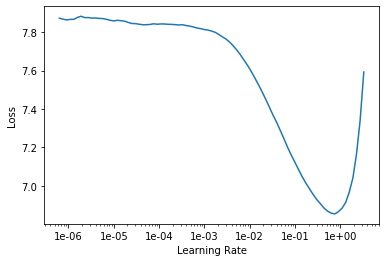

In [105]:
learn.lr_find()
learn.recorder.plot()

In [106]:
learn.fit_one_cycle(1, 5.0E-02, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,5.506296,4.878209,0.179322,00:04


In [0]:
learn.unfreeze()

In [108]:
learn.fit_one_cycle(3, 5.0E-03, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,4.701272,4.706405,0.192817,00:05
1,4.395278,4.601561,0.207934,00:05
2,3.828188,4.709075,0.208300,00:05


### Predicting with Learning Model

In [109]:
learn.predict('My flight is great!', n_words=20)

'My flight is great! this wifi be just promo kick me from hour incoming clear xxbos southwestair your new phone system suck relate flightd'

In [0]:
learn.save_encoder('ft_enc')

In [0]:
train_valid, test = train_test_split(df, test_size=0.2)
train, valid = train_test_split(train_valid, test_size=0.2)

In [0]:
data_clas = TextClasDataBunch.from_df(working_path, train, valid, test_df=test, vocab=data_lm.train_ds.vocab, text_cols='text_html', label_cols='airline_sentiment', bs=32)

In [115]:
data_clas.show_batch()

text,target
xxbos southwestair twitter cust svc rule 1 do nt say if we fell short just tell u u do 2 if u ca nt solve problem do nt say anything at all,negative
xxbos jetblue jetblue but be on flt xxunk from fll sfo xxunk off be over 1 hr late flight div phx amp get in 2 hr late flight what will be do,negative
xxbos usairways be on xxunk for 1hr and xxunk at xxunk since my flgt from dca msy be cancel flightled still try get out on hold now 50min xxrep 4 s,negative
xxbos ha … rebooked me in an 11 hr layover amp be rob me of night with my family too late flight for that just fly on time for once,negative
xxbos usairways 4 segment xxunk delay xxunk gt ctl ctl gt jan jan gt ctl ctl gt xxunk my year off from fly with guy be way go,negative


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


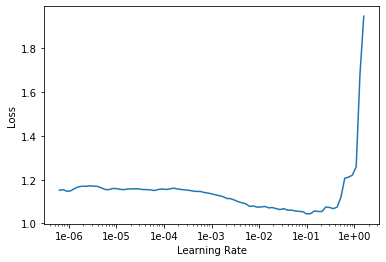

In [117]:
learn.lr_find()
learn.recorder.plot()

In [118]:
lr = 5E-02
learn.fit_one_cycle(2, lr, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.792638,0.658274,0.720871,00:03
1,0.711299,0.562097,0.778489,00:04


In [119]:
learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(3, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.651323,0.653240,0.743064,00:04
1,0.616504,0.507839,0.801110,00:04
2,0.548968,0.489003,0.807512,00:04


In [120]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(3, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.566978,0.502024,0.793854,00:06
1,0.510714,0.492011,0.805805,00:06
2,0.368630,0.539144,0.806658,00:06


In [121]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(3, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.283212,0.579273,0.806231,00:08
1,0.265834,0.590552,0.807085,00:08
2,0.170052,0.589258,0.806658,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


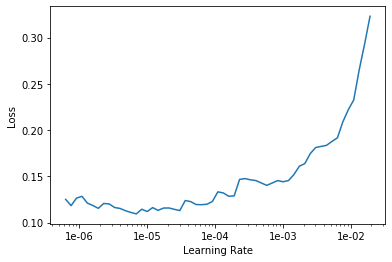

In [122]:
learn.lr_find()
learn.recorder.plot()

In [123]:
learn.predict('I love flying')

(Category positive, tensor(2), tensor([8.7523e-04, 4.7319e-03, 9.9439e-01]))

In [124]:
learn.predict('My flight was delayed')

(Category negative, tensor(0), tensor([0.7681, 0.2276, 0.0043]))

In [125]:
learn.predict("Safe flight!")

(Category positive, tensor(2), tensor([0.1233, 0.2479, 0.6288]))

## Accuracy

In [126]:
interp = TextClassificationInterpretation.from_learner(learn)
acc = accuracy(interp.preds, interp.y_true)
print('Accuracy: {0:.3f}'.format(acc))

Accuracy: 0.807


## Confusion Matrix

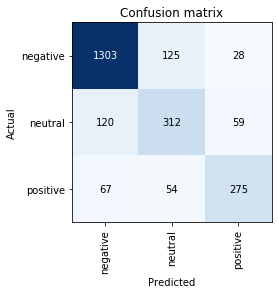

In [127]:
interp.plot_confusion_matrix()

## ROC and AUC Curve
Now we plot the one vs. rest ROC curves and give the corresponding AUC values. The one vs. rest ROC curves are a generalization where we choose one class to be the Positive class and combine the rest.

Text(0, 0.5, 'True Positive Rate')

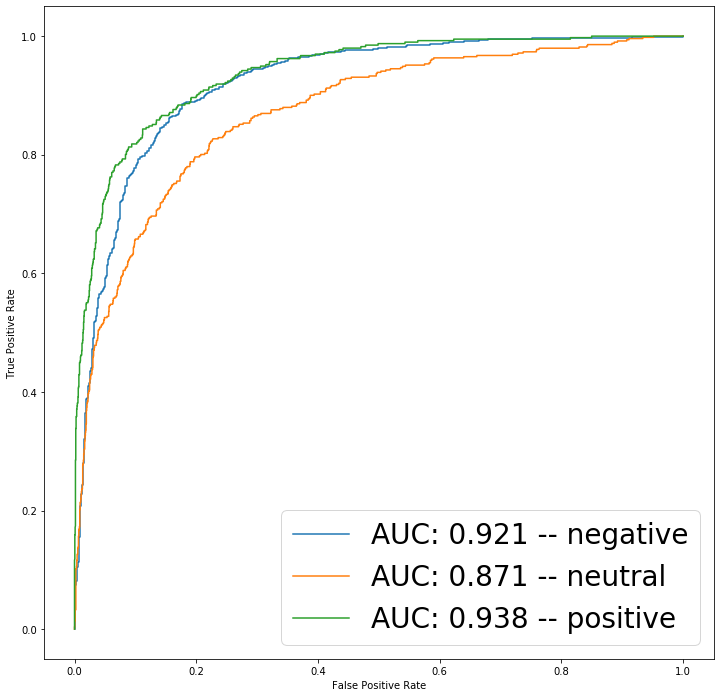

In [128]:
scores = pd.DataFrame(interp.preds)
plt.figure(figsize=(12, 12))
fpr = dict()
tpr = dict()
thresh = dict()
for i, cls in zip(range(3), ['negative', 'neutral', 'positive']):
    score = scores[i].apply(lambda x: x.item())
    y_true = [x.item() == i for x in interp.y_true]
    fpr[i], tpr[i], thresh[i] = roc_curve(y_true, score, pos_label=True)
    auc = roc_auc_score(y_true, score)
    leg = "AUC: {0:.3f} -- {1}".format(float(auc), cls)
    plt.plot(fpr[i], tpr[i], label=leg)
    
plt.legend(loc="lower right", prop={'size': 28})
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')